In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from util.cifar10_loader import Cifar10Loader
from util.data_visualizer import DataVisualizer

### Load and Visualize CIFAR 10 Data into train, test

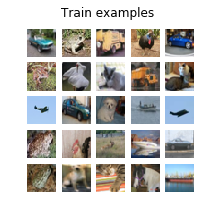

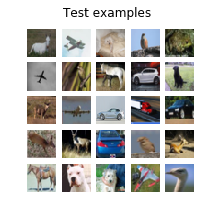

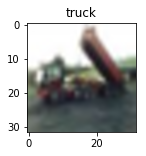

In [2]:
model_path = './models'
data_loader = Cifar10Loader()
dv = DataVisualizer()

X_train_cifar, y_train_cifar, X_test_cifar, y_test_cifar, labels = data_loader.load_cifar10('./Datasets/cifar-10')

# data_visualizer expects unflatted images
dv.visualize_data(X_train_cifar, 'Train examples')
dv.visualize_data(X_test_cifar, 'Test examples')

# Flatten data
X_train_cifar = X_train_cifar.reshape(X_train_cifar.shape[0], -1)
X_test_cifar = X_test_cifar.reshape(X_test_cifar.shape[0], -1)

# Verify Flattened data
image_id = 2
dv.visualize_image(X_train_cifar[image_id].reshape(32, 32, 3), labels[y_train_cifar[image_id]])

# Utilities

In [3]:
from scipy.special import expit

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_alternate(x):
    return expit(x)

# Division by Std dev not needed as the initial image is already in range of 0 to 1 
# due to earlier division by 255. So now all the different features (pixels) are in similar scale.
def scale_features(X, X_mean=None, X_std=None, divide_by_std_dev=False, view_hists=False):
    if X_mean is None:
        X_mean = np.mean(X, axis=0)
    if X_std is None:
        X_std = np.std(X, axis=0)
    X_1 = X - X_mean
    X_2 = X_1/X_std

    if view_hists == True:
        fig, axes1 = plt.subplots(3,1,figsize=(7,7))
        plt.suptitle('Histogram of 0th pixel of all examples')
        axes1[0].set_title('data')
        axes1[0].hist(X[:,0])
        axes1[1].set_title('data - Mean(data)')
        axes1[1].hist(X_1[:,0])
        axes1[2].set_title('(data - Mean(data))/Std_dev(data)')
        axes1[2].hist(X_2[:,0])

    if divide_by_std_dev is True:
        return X_2, X_mean, X_std
    else:
        return X_1, X_mean, X_std

def append_ones(X):
    return np.concatenate((X, np.ones((X.shape[0], 1), dtype=int)), axis=1)

def generate_binary_classification_label_from_multiclass_labels(labels, num_classes):
    # Generate 10 sets of labels for each class
    binary_labels = np.zeros((10, labels.shape[0]), dtype=int)
    for i in range(num_classes):
        binary_labels[i] = (labels == i)
    return binary_labels

# SVM Classification

#### Concepts / Learnings:
- Performance supposedly comparable to Softmax but results don't say that!
- SVM has a non-differential loss function and is called hinge loss or max margin loss

#### SVM classification:
    - y can be 0, 1, .., (number of classes - 1)
    - y_scores = W.X
    - y_predictions = argmax(y_scores)
    - loss per example = [sum over all classes c except y: max(0, y_score for c - y_score for y + delta)]
    - overall loss = [sum over all examples and normalize: loss per example]
    - loss_derivative = 
            for all classes c except y: if y_score for c - y_score for y + delta > 0, then 1, else 0
            for class c = y: - [sum over loss_derivative] 
    - Gradient descent: W = W - learning_rate \* [sum over all examples and normalize: loss_derivative \* X]

#### Experiments:
- Experiment 1:
        Accuracy on Training data = 34.3525
        Accuracy on Test data = 31.6
    These results are comparable to the svm on cifar 10 exp at https://houxianxu.github.io/implementation/SVM.html
    
#### TODO:
- Use http://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html#sphx-glr-auto-examples-datasets-plot-random-dataset-py to check if SVM is working fine and to draw decision boundary

In [276]:
import time

class SVMClassification():
    def __init__(self, verbose=True):
        self.weights = None
        self.verbose = verbose
        self.loss_list = []
        self.accuracy_list = []
        self.val_accuracy_list = []
        self.val_loss_list = []
        
    def _initialize_weights(self):
        self.loss_list = []
        self.accuracy_list = []
        self.val_accuracy_list = []  
        self.val_loss_list = []
        # define weights - random from uniform distribution over [0,1] or initialize to 0?
        self.weights = np.random.rand(self.num_classes, self.num_features)/self.num_train_data

    def _plot(self, list1, label1, list2=None, label2=None, title='Plot'):
        plt.figure()
        plt.title(title)
        plt.plot(list1, 'r', label=label1)
        if list2 is not None and list2 is not []:
            plt.plot(list2, 'b', label=label2)
        plt.legend()

    def _forward_propagate(self, X):
        y_score = np.dot(X, self.weights.T)
        y_pred = np.argmax(y_score, axis=1)
        return y_score, y_pred
    
    def _compute_loss(self, y, y_score):
        loss_scores = y_score - y_score[np.arange(y_score.shape[0]), y].reshape(-1, 1) + self.delta
        # Converting the scores at the y location to 0 so it doesn't affect the max() operation
        loss_scores[np.arange(y_score.shape[0]), y] -= self.delta
        loss_hinge = np.sum(np.maximum(np.zeros(loss_scores.shape), loss_scores))/y.shape[0]
        return loss_hinge
    
    def _compute_loss_derivative(self, X, y, y_score):
        loss_scores = y_score - y_score[np.arange(y_score.shape[0]), y].reshape(-1, 1) + self.delta
        # Converting the scores at the y location to 0 so it doesn't affect the max() operation
        loss_scores[np.arange(y_score.shape[0]), y] -= self.delta
        loss_scores[loss_scores > 0] = 1
        loss_scores[loss_scores <= 0] = 0
        loss_scores[np.arange(y_score.shape[0]), y] = -np.sum(loss_scores, axis=1)
        loss_derivative = np.dot(loss_scores.T, X)
        return loss_derivative

    def _update_weights(self, loss_derivative):
        self.weights = self.weights - (self.learning_rate / self.num_train_data) * loss_derivative
        
    def train(self, X, y, num_epochs, X_val=None, y_val=None, learning_rate=0.01, delta=1, initialize_weights=False, 
              gradient_descent_type='batch', enable_regularization=False, regularization_rate=0.1):
        """
        Train the classifier
        Parameters
        ----------
        X: (N x M) nd-array of dtype=float where N is the size of train dataset, M is the number of features
        y: (N x 1) nd-array of dtype=int where N is the size of train dataset
        """
        self.num_train_data = X.shape[0]
        self.num_features = X.shape[1]
        self.num_classes = np.unique(y).shape[0]
        self.learning_rate = learning_rate
        self.delta = delta
        if self.num_train_data != y.shape[0]:
            raise ValueError("Train Data size and Label size don't match")

        if self.weights is None or initialize_weights is True:
            self._initialize_weights()

        for i in range(num_epochs):

            y_score, y_pred = self._forward_propagate(X)
            loss_hinge = self._compute_loss(y, y_score)
            acc = self.get_accuracy(y, y_pred)

            if X_val is not None:
                y_val_score, y_val_pred = self._forward_propagate(X_val)
                val_loss_hinge = self._compute_loss(y_val, y_val_score)
                val_acc = self.get_accuracy(y_val, y_val_pred)

            if enable_regularization is True:
                # Don't include bias while summing up weights
                regularization_penalty = regularization_rate * np.sum(np.square(self.weights[:,:-1]))
                loss_hinge = loss_hinge + regularization_penalty
                if X_val is not None:
                    val_loss_hinge = val_loss_hinge + regularization_penalty
            
            # Back Propagation
            loss_derivative = self._compute_loss_derivative(X, y, y_score)
            self._update_weights(loss_derivative)

            if enable_regularization is True:
                self.weights = self.weights - (learning_rate * regularization_rate)*self.weights

            self.loss_list.append(loss_hinge)
            self.accuracy_list.append(acc)
            if X_val is not None:
                self.val_accuracy_list.append(val_acc)
                self.val_loss_list.append(val_loss_hinge)
            
            if self.verbose is True and i%100 == 0:
                print('Iteration {}: Accuracy = {} Loss = {}'.format(i, acc, loss_hinge))
                
        self._plot(self.loss_list, 'Training Loss', self.val_loss_list, 'Validation Loss', 
                   title='Training and Validation Loss')
        self._plot(self.accuracy_list, 'Training Accuracy', self.val_accuracy_list, 'Validation Accuracy', 
                   title='Training and Validation Accuracy')
        
    def predict(self, X):
        _, y_pred = self._forward_propagate(X)
        return y_pred
    
    def get_accuracy(self, y_ground_truth, y_predicted):
        """
        Computes accuracy
        Parameters
        ----------
        y_ground_truth: (N x 1) nd-array of dtype=int
        y_predicted: (N x 1) nd-array of dtype=int
        Returns:
        accuracy of type float
        """
        return(100*np.mean(y_predicted == y_ground_truth))
    
    def save_model(self, filename):
        np.save(filename, self.weights)

    def load_model(self, filename):
        self.weights = np.load(filename)

    def visualize_weights(self, label_names, h_plots=5, figsize=(12,12), interpolation='spline16'):
        num_classes = self.weights.shape[0]
        v_plots = num_classes / h_plots
        if v_plots%1 != 0:
            print("h_plots can't be supported")
            return
        fig, axes1 = plt.subplots(int(v_plots), h_plots, figsize=figsize)
        print("Bias = ", self.weights[:,-1])
        for i in range(int(v_plots)):
            for j in range(h_plots):
                k = i*h_plots + j
                weight_image = self.weights[k][:-1]
                weight_min = np.min(weight_image)
                weight_max = np.max(weight_image)
                weight_image_0_1 = (weight_image - weight_min)/(weight_max - weight_min)
                axes1[i][j].set_aspect('equal')
                axes1[i][j].set_title(label_names[k])
                axes1[i][j].imshow(weight_image_0_1.reshape(32, 32, 3), interpolation=interpolation)

### Generate Correct Features and Labels

In [36]:
def preprocess_features(train_features, test_features, divide_by_std_dev=True):
    X_train, X_mean, X_std = scale_features(train_features, divide_by_std_dev=divide_by_std_dev, view_hists=False)
    X_train = append_ones(X_train)

    X_test,_,_ = scale_features(test_features, X_mean=X_mean, X_std=X_std, divide_by_std_dev=divide_by_std_dev, view_hists=False)
    X_test = append_ones(X_test)
    return X_train, X_test

def get_binary_labels_for_class(train_labels, test_labels, class_id):
    train_labels_binary = generate_binary_classification_label_from_multiclass_labels(train_labels, 10)
    y_train = train_labels_binary[class_id].reshape(-1, 1)

    test_labels_binary = generate_binary_classification_label_from_multiclass_labels(test_labels, 10)
    y_test = test_labels_binary[class_id].reshape(-1, 1)
    return y_train, y_test

### Split training into training and validation data

In [37]:
def split_train_validation_data(X, y, split=0.8):
    indexes = np.arange(X.shape[0])
    np.random.shuffle(indexes)
    X_train = X[indexes[:int(split*X.shape[0])]]
    y_train = y[indexes[:int(split*X.shape[0])]]    
    X_val = X[indexes[int(split*X.shape[0]):]]
    y_val = y[indexes[int(split*X.shape[0]):]]    
    return X_train, y_train, X_val, y_val

## Experiment 1

Iteration 0: Accuracy = 9.3125 Loss = 9.000193958117983
Iteration 100: Accuracy = 32.2425 Loss = 7.056690878351731
Iteration 200: Accuracy = 33.1 Loss = 6.857814091774224
Iteration 300: Accuracy = 33.675 Loss = 6.811442418499813
Iteration 400: Accuracy = 33.8575 Loss = 6.775647929463403
Iteration 500: Accuracy = 33.9225 Loss = 6.761479984453129
Iteration 600: Accuracy = 34.13 Loss = 6.708378584744759
Iteration 700: Accuracy = 34.1575 Loss = 6.734224871569851
Iteration 800: Accuracy = 34.38 Loss = 6.69371193542012
Iteration 900: Accuracy = 34.247499999999995 Loss = 6.740079277931665
Iteration 1000: Accuracy = 34.33 Loss = 6.750773502710797
Iteration 1100: Accuracy = 34.445 Loss = 6.707412101345607
Iteration 1200: Accuracy = 34.505 Loss = 6.728796927168737
Iteration 1300: Accuracy = 34.4075 Loss = 6.762047007647102
Iteration 1400: Accuracy = 34.485 Loss = 6.749304118346215
Iteration 1500: Accuracy = 34.5625 Loss = 6.677762909746504
Iteration 1600: Accuracy = 34.362500000000004 Loss = 6.7

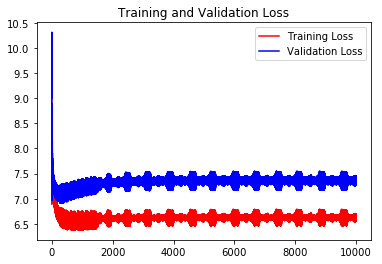

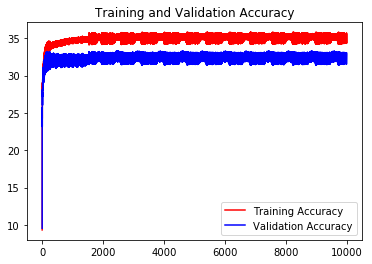

In [43]:
X_train, X_test = preprocess_features(X_train_cifar, X_test_cifar, divide_by_std_dev=True)
y_train, y_test = y_train_cifar, y_test_cifar
X_train, y_train, X_val, y_val = split_train_validation_data(X_train, y_train, split=0.8)

num_epochs = 10000
svm = SVMClassification()
svm.train(X_train, y_train, num_epochs=num_epochs, X_val=X_val, y_val=y_val, learning_rate=0.01, delta=1,
         enable_regularization=True, regularization_rate=0.1)

Accuracy on Training data = 34.3375
Accuracy on Test data = 31.56
Bias =  [-0.05991392 -0.11055016  0.1757409   0.20722278  0.174857    0.16287593
 -0.13818389  0.10392833 -0.34121821 -0.17475875]


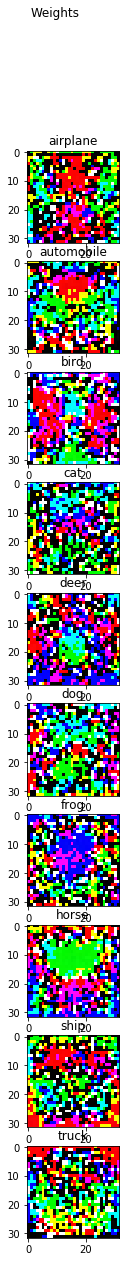

In [44]:
model_file = "svm_classification_cifar10_epochs{}_{}.npy".format(num_epochs, time.strftime("%Y_%m_%d-%H_%M_%S"))
model_file = '/'.join([model_path, model_file])
svm.save_model(model_file)

y_pred = svm.predict(X_train)
print("Accuracy on Training data = {}".format(svm.get_accuracy(y_train, y_pred)))

y_pred = svm.predict(X_test)
print("Accuracy on Test data = {}".format(svm.get_accuracy(y_test, y_pred)))

svm.visualize_weights(labels)

Bias =  [-0.05991392 -0.11055016  0.1757409   0.20722278  0.174857    0.16287593
 -0.13818389  0.10392833 -0.34121821 -0.17475875]


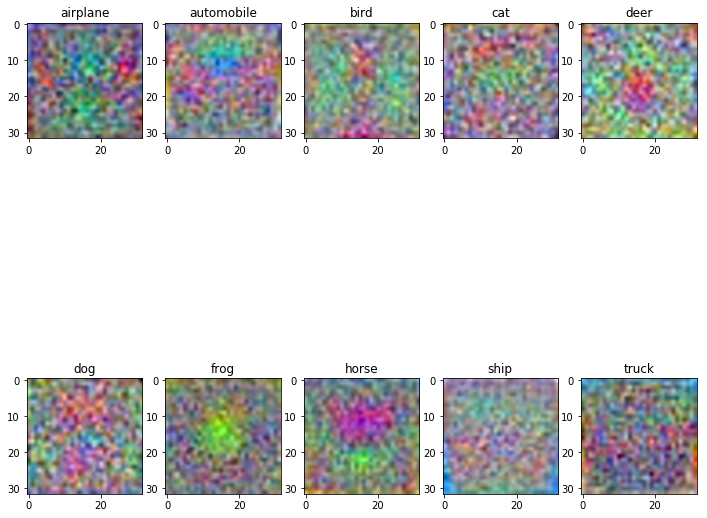

In [277]:
svm = SVMClassification()
svm.load_model('./models/svm_classification_cifar10_epochs10000_2017_05_04-14_39_14.npy')
svm.visualize_weights(labels)

Iteration 0: Accuracy = 34.3375 Loss = 6.679833279303897
Iteration 100: Accuracy = 34.325 Loss = 6.681811953719461
Iteration 200: Accuracy = 34.8525 Loss = 6.782457837475256
Iteration 300: Accuracy = 34.870000000000005 Loss = 6.768662010473765
Iteration 400: Accuracy = 34.275 Loss = 6.666996501334818
Iteration 500: Accuracy = 34.32 Loss = 6.662942116270292
Iteration 600: Accuracy = 34.425 Loss = 6.691696052299181
Iteration 700: Accuracy = 34.3575 Loss = 6.659024718638811
Iteration 800: Accuracy = 34.385 Loss = 6.653826909260207
Iteration 900: Accuracy = 34.71 Loss = 6.740152236730943
Iteration 1000: Accuracy = 34.8925 Loss = 6.767422228585897
Iteration 1100: Accuracy = 34.307500000000005 Loss = 6.66283751735415
Iteration 1200: Accuracy = 34.3125 Loss = 6.659935201165581
Iteration 1300: Accuracy = 34.497499999999995 Loss = 6.708916968846086
Iteration 1400: Accuracy = 34.355000000000004 Loss = 6.677327081629462
Iteration 1500: Accuracy = 34.339999999999996 Loss = 6.655688788988689
Iterat

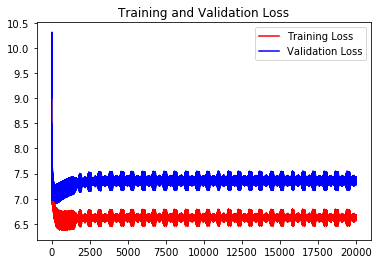

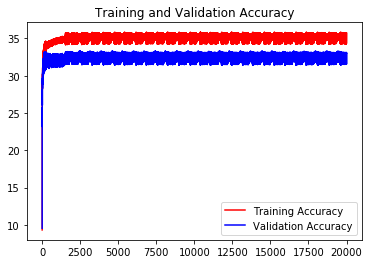

In [45]:
svm.train(X_train, y_train, num_epochs=num_epochs, X_val=X_val, y_val=y_val, learning_rate=0.01, delta=1,
         enable_regularization=True, regularization_rate=0.1)
total_epochs=2*num_epochs

Accuracy on Training data = 34.3525
Accuracy on Test data = 31.6
Bias =  [-0.05980065 -0.10953131  0.17520425  0.20756812  0.17557579  0.15925027
 -0.13498018  0.10270016 -0.34072987 -0.17525658]


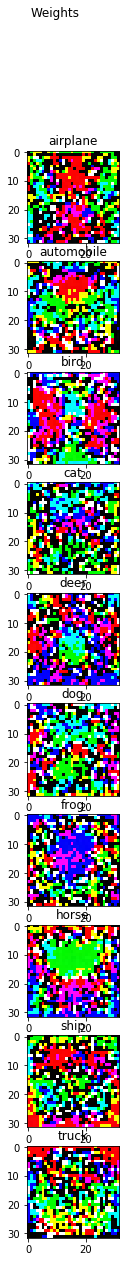

In [46]:
model_file = "svm_classification_cifar10_epochs{}_{}.npy".format(total_epochs, time.strftime("%Y_%m_%d-%H_%M_%S"))
model_file = '/'.join([model_path, model_file])
svm.save_model(model_file)

y_pred = svm.predict(X_train)
print("Accuracy on Training data = {}".format(svm.get_accuracy(y_train, y_pred)))

y_pred = svm.predict(X_test)
print("Accuracy on Test data = {}".format(svm.get_accuracy(y_test, y_pred)))

svm.visualize_weights(labels)

### Experiment 2 - smaller legible dataset!

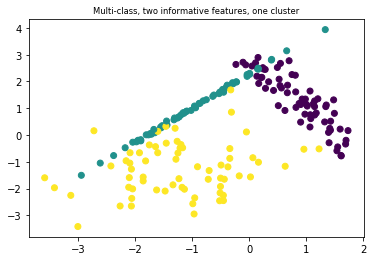

In [200]:
from sklearn.datasets import make_classification
n_samples=200
X1, Y1 = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=3)
plt.title("Multi-class, two informative features, one cluster", fontsize='small')
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1)

In [201]:
X_train, y_train, X_test, y_test = split_train_validation_data(X1, Y1, split=0.9)
X_train, X_test = preprocess_features(X_train, X_test, divide_by_std_dev=True)
X_train, y_train, X_val, y_val = split_train_validation_data(X_train, y_train, split=0.9)

Iteration 0: Accuracy = 24.691358024691358 Loss = 2.005516596706558
Iteration 100: Accuracy = 85.18518518518519 Loss = 0.6860388730604641
Iteration 200: Accuracy = 87.03703703703704 Loss = 0.6343660043121968


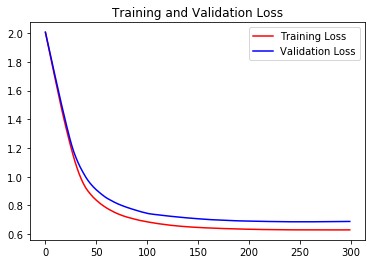

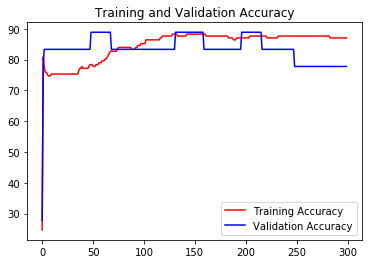

In [202]:
num_epochs = 300
svm = SVMClassification()
svm.train(X_train, y_train, num_epochs=num_epochs, X_val=X_val, y_val=y_val, learning_rate=0.01, delta=1,
         enable_regularization=True, regularization_rate=0.1)

In [203]:
y_pred = svm.predict(X_test)
print("Accuracy on Test data = {}".format(svm.get_accuracy(y_test, y_pred)))

Accuracy on Test data = 85.0


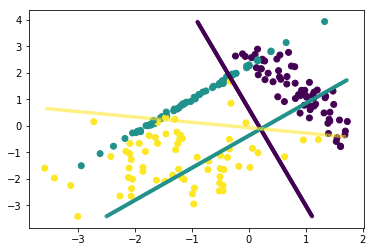

In [207]:
plot_decision_boundary_for_2_features(X1, Y1, svm.weights)

In [206]:
# plt.plot(x, y, linestyle="dashed", marker="o", color="green")
# Instead of the complicated np.where(), we could have just used plt.xlim(0.5,4.5) and ylim!

def plot_decision_boundary_for_2_features(X, Y, weights):
    X_Y_min = np.min(X, axis=0)
    X_Y_max = np.max(X, axis=0)

    # y here the second feature of X and not the label.
    y = np.arange(X_Y_min[1], X_Y_max[1], 0.01)
    y_plot = np.array([])
    x_plot = np.array([])
    c_plot = np.array([])

    for i, w in enumerate(weights):
        x_i = -(w[2] / w[0]) - (w[1] / w[0])*y
        ind = np.array(np.where((x_i >= X_Y_min[0]) & (x_i <= X_Y_max[0]))).flatten()
        x_good = x_i[ind]
        y_good = y[ind]
        c_good = np.zeros(x_good.shape, dtype=int) + i
        x_plot = np.concatenate((x_plot, x_good), axis=0)
        y_plot = np.concatenate((y_plot, y_good), axis=0)
        c_plot = np.concatenate((c_plot, c_good), axis=0)

    plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y)
    plt.scatter(x_plot, y_plot, alpha=0.4, marker='.', c=c_plot)   